<h3> Análisis de variabilidad climática en Nevados Colombianos mediante datos de TerraClimate y Google Earth Engine 1960 - 2022 </h3>
<p><strong>Nombre: </strong> Juan Sebastián Hernández Santana </p>
<p><strong>Fecha: </strong> 21 de Diciembre de 2023 </p>

In [49]:
# Conexión con Google Earth Engine
import geemap
import ee
# Manejo de datos
import pandas as pd
import numpy as np
# Manejo de gráficos
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Funciones

# Recortar las imágenes de la colección
def clip_image(img):
    return img.clip(nevado).copyProperties(img, ["system:time_start"])
# Aplicar el factor de escala para TerraClimate (0.1)
def scale_image(img):
    return img.multiply(0.1).copyProperties(img,["system:time_start"])
# Obtener métricas de temperatura máxima y mínima de la zona de estudio
def obtener_temp_extrema(coleccion, banda, tipo):
    temp_extrema = coleccion \
        .filterDate("1960-01-01", "2022-12-31") \
        .filterBounds(nevado) \
        .select(banda) \
        .map(lambda image: image.clip(nevado)) \
        .map(lambda image: image.multiply(0.1))
    
    if tipo == 'max':
        return temp_extrema.max().reduceRegion(**{
            "reducer": ee.Reducer.max(),
            "geometry": nevado,
            "scale": 4638.312116386398,
            "maxPixels": 1e9
        })
    elif tipo == 'min':
        return temp_extrema.min().reduceRegion(**{
            "reducer": ee.Reducer.min(),
            "geometry": nevado,
            "scale": 4638.312116386398,
            "maxPixels": 1e9
        })
# Extraer temperatura promedio por medio de temperaturas máximas y mínimas
def extract_temp_mean(img):
    maximos = img.select("tmmx").clip(nevado).multiply(0.1)
    minimos = img.select("tmmn").clip(nevado).multiply(0.1)
    promedio = (maximos.add(minimos)).divide(2)
    return promedio.rename("prom").copyProperties(img,["system:time_start"])
# Extraer el promedio de cada imagen de las temperaturas promedio
def temp_mean_reductor(img, tipo): 
    temp_mean_mean = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = nevado, scale = 4638.312116386398).get(tipo)
    return img.set('Fecha', img.date().format()).set('Promedio', temp_mean_mean)


In [51]:
ee.Initialize()

Nevados disponibles para extracción

In [121]:
list_nevados = ['Nevado_Cocuy', 'Nevado_Huila', 'Nevado_Purace', 'Nevado_Nevados']
name_nevado = list_nevados[3] # Seleccionar el nevado de interés

TerraClimate: Monthly Climate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idahovv

In [122]:
image_collection = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")

Geometría de los nevados

In [123]:
nevado = geemap.shp_to_ee('./Shapefile_Nevados/{}.shp'.format(name_nevado))

Extracción de colección de imágenes desde 1960 a 2022 con la geometría del Nevado y aplicando recorte y factor de escala

In [124]:
temp_max = image_collection.filterDate("1960-01-01","2022-12-31").filterBounds(nevado).select("tmmx").map(clip_image).map(scale_image)
temp_min = image_collection.filterDate("1960-01-01","2022-12-31").filterBounds(nevado).select("tmmn").map(clip_image).map(scale_image)

Encontrar las métricas de la temperatura para el Nevado

In [125]:
max_temp_max = obtener_temp_extrema(image_collection, "tmmx", 'max')
min_temp_max = obtener_temp_extrema(image_collection, "tmmn", 'max')
max_temp_min = obtener_temp_extrema(image_collection, "tmmx", 'min')
min_temp_min = obtener_temp_extrema(image_collection, "tmmn", 'min')

max_temp_max_value = float(max_temp_max.getInfo().get('tmmx'))
min_temp_max_value = float(min_temp_max.getInfo().get('tmmn'))
max_temp_min_value = float(max_temp_min.getInfo().get('tmmx'))
min_temp_min_value = float(min_temp_min.getInfo().get('tmmn'))

data = {
    'Temp_Max_TodaSerie_MaxPx': [max_temp_max_value],
    'Temp_Min_TodaSerie_MaxPx': [min_temp_max_value],
    'Temp_Max_TodaSerie_MinPx': [max_temp_min_value],
    'Temp_Min_TodaSerie_MinPx': [min_temp_min_value]
}

df_resumen = pd.DataFrame(data)
df_resumen

,Temp_Max_TodaSerie_MaxPx,Temp_Min_TodaSerie_MaxPx,Temp_Max_TodaSerie_MinPx,Temp_Min_TodaSerie_MinPx
0,19.8,12.2,1.5,-5.7


Ilustración de temperatura máxima y mínima

In [126]:
palette_max = ['green', 'red']
palette_min = ['blue', 'red']

Map = geemap.Map()

Map.addLayer(temp_max.max(), {"palette": palette_max, "min": df_resumen['Temp_Max_TodaSerie_MinPx'][0], "max": df_resumen['Temp_Max_TodaSerie_MaxPx'][0]}, "Temperatura máxima")
Map.addLayer(temp_min.min(), {"palette": palette_min, "min": df_resumen['Temp_Min_TodaSerie_MinPx'][0], "max": df_resumen['Temp_Max_TodaSerie_MaxPx'][0]}, "Temperatura mínima")

Map.centerObject(nevado, 10)
Map

Map(center=[4.767923084049246, -75.38180781607835], controls=(WidgetControl(options=['position', 'transparent_…

In [127]:
temp_mean = image_collection.filterDate("1960-01-01", "2022-12-31").filterBounds(nevado).map(extract_temp_mean)

In [128]:
temp_mean_temp_max = float(temp_mean.max().reduceRegion(**{
                              "reducer": ee.Reducer.max(),
                              "geometry": nevado,
                              "scale": 4638.312116386398,  #Tamaño del px
                              "maxPixels": 1e9
                            }).getInfo().get('prom'))

print("Temperatura maxima de los promedios de todo el periodo y todos lo px: {}".format(temp_mean_temp_max))

Temperatura maxima de los promedios de todo el periodo y todos lo px: 14.55


In [129]:
temp_mean_temp_min = float(temp_mean.min().reduceRegion(**{
                              "reducer": ee.Reducer.min(),
                              "geometry": nevado,
                              "scale": 4638.312116386398,  #Tamaño del px
                              "maxPixels": 1e9
                            }).getInfo().get('prom'))

print("Temperatura mínima de los promedios de todo el periodo y todos lo px: {}".format(temp_mean_temp_min))

Temperatura mínima de los promedios de todo el periodo y todos lo px: -1.0000000000000002


In [130]:
Map.addLayer(temp_mean.mean(), {"palette": palette_max, "min": temp_mean_temp_min, "max": temp_mean_temp_max}, "Temperaturas promedio multianuales")
Map

Map(center=[4.767923084049246, -75.38180781607835], controls=(WidgetControl(options=['position', 'transparent_…

In [131]:
Tprom_reducido_imgs = temp_mean.map(lambda img: temp_mean_reductor(img, 'prom'))
anidar_listaTprom = Tprom_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tprom = pd.DataFrame(anidar_listaTprom.getInfo(), columns=['Fecha','Promedio'])
df_Tprom['Fecha'] = pd.to_datetime(df_Tprom['Fecha'])
df_Tprom = df_Tprom.set_index('Fecha')

df_Tprom

,Promedio
Fecha,
1960-01-01,5.378291
1960-02-01,5.749421
1960-03-01,5.687320
1960-04-01,5.510012
1960-05-01,5.894468
...,...
2022-08-01,5.749077
2022-09-01,5.840884
2022-10-01,5.748619


In [132]:
Tmax_reducido_imgs = temp_max.map(lambda img: temp_mean_reductor(img, 'tmmx'))
anidar_listaTmax = Tmax_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tmax = pd.DataFrame(anidar_listaTmax.getInfo(), columns=['Fecha','Promedio'])
df_Tmax['Fecha'] = pd.to_datetime(df_Tmax['Fecha'])
df_Tmax = df_Tmax.set_index('Fecha')

df_Tmax

,Promedio
Fecha,
1960-01-01,10.847770
1960-02-01,10.947891
1960-03-01,10.966096
1960-04-01,10.268589
1960-05-01,10.379531
...,...
2022-08-01,9.226883
2022-09-01,9.516278
2022-10-01,9.221897


In [133]:
Tmin_reducido_imgs = temp_min.map(lambda img: temp_mean_reductor(img, 'tmmn'))
anidar_listaTmin = Tmin_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)
df_Tmin = pd.DataFrame(anidar_listaTmin.getInfo(), columns=['Fecha','Promedio'])
df_Tmin['Fecha'] = pd.to_datetime(df_Tmin['Fecha'])
df_Tmin = df_Tmin.set_index('Fecha')

df_Tmin

,Promedio
Fecha,
1960-01-01,-0.091187
1960-02-01,0.550950
1960-03-01,0.408543
1960-04-01,0.751435
1960-05-01,1.409406
...,...
2022-08-01,2.271271
2022-09-01,2.165490
2022-10-01,2.275340


In [200]:
intervalos_confianza

,lower Promedio,upper Promedio
2022-01-01,5.679244,7.092605
2022-02-01,5.597617,7.151707
2022-03-01,5.490395,7.185016
2022-04-01,5.463869,7.252147
2022-05-01,5.651501,7.519863
2022-06-01,5.460530,7.388510
2022-07-01,5.477423,7.507793
2022-08-01,5.402038,7.517003
2022-09-01,5.324112,7.515634
2022-10-01,5.332706,7.573065


In [213]:
ultima_fecha

Timestamp('2021-12-01 00:00:00')

In [216]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

df_temperatura_10_last_month = df_Tprom[:-12]

modelo_Tmin = ARIMA(df_temperatura_10_last_month['Promedio'], order = (120, 1, 0))
modelo_Tmin_entrenado = modelo_Tmin.fit()

n = 12
prediccion_Tmin = modelo_Tmin_entrenado.forecast(steps=n)

ultima_fecha = df_temperatura_10_last_month.index[-1]

indice_fechas = pd.date_range(start=ultima_fecha + pd.DateOffset(days=1), periods=n, freq='MS')  

predicciones_df = pd.DataFrame({'Prediccion_Tmin': prediccion_Tmin}, index=indice_fechas)

prediccion = modelo_Tmin_entrenado.get_forecast(steps=n)

intervalos_confianza = prediccion.conf_int()

limites_df = pd.DataFrame({'Limite superior': intervalos_confianza['upper Promedio'], 'Limite inferior': intervalos_confianza['lower Promedio']}, index=indice_fechas)

plt.figure(figsize=(10, 6))
plt.plot(df_Tprom.index, df_Tprom['Promedio'], label='Observado', color='blue')
plt.plot(predicciones_df.index, predicciones_df['Prediccion_Tmin'], label='Predicción', color='red')
plt.fill_between(limites_df.index, limites_df['Limite inferior'], limites_df['Limite superior'], alpha=0.3)
plt.xlim(df_Tprom.index[-160])
plt.xlabel('Fecha')
plt.ylabel('Temperatura mínima')
plt.title('Predicción de temperatura mínima con intervalo de confianza')
plt.legend()
plt.show()

observado = df_Tprom[-12:]
mse = mean_squared_error(observado['Promedio'], predicciones_df['Prediccion_Tmin'])
mae = mean_absolute_error(observado['Promedio'], predicciones_df['Prediccion_Tmin'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Temperaturas del Nevado (Enero de 1960 a Diciembre de 2022)')

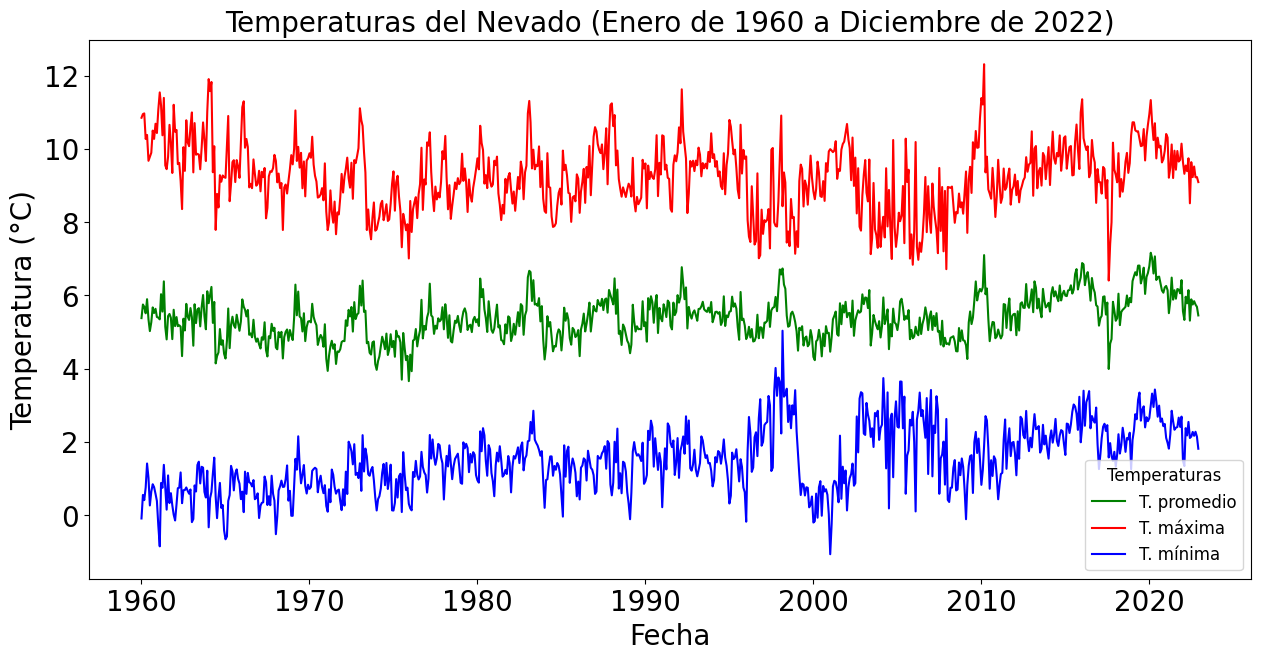

In [134]:
fig, ax = plt.subplots(figsize = (15,7))

sns.lineplot(data=df_Tprom, ax=ax, palette =["g"], legend=False,label="T. promedio")
sns.lineplot(data=df_Tmax, ax=ax, palette =["r"], legend=False,label="T. máxima")
sns.lineplot(data=df_Tmin, ax=ax, palette =["b"], legend=False,label="T. mínima")

ax.legend(title="Temperaturas",title_fontsize=12,fontsize=12, loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_ylabel('Temperatura (°C)',fontsize=20)
ax.set_xlabel('Fecha',fontsize=20)
ax.set_title('Temperaturas del Nevado (Enero de 1960 a Diciembre de 2022)',fontsize=20)

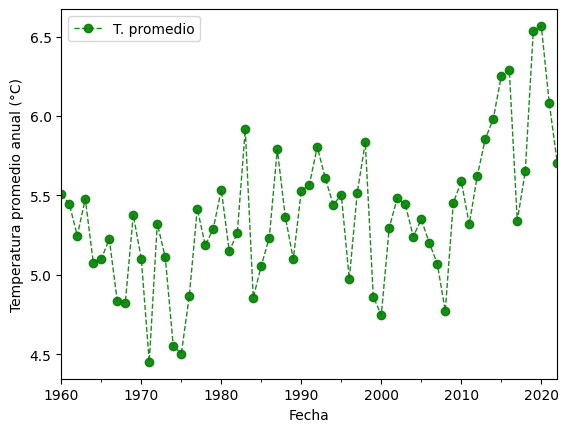

In [135]:
df_Tprom.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura promedio anual (°C)",
                                                   color="g", alpha=0.9, style="--", lw=1,
                                                  marker="o")
plt.legend(["T. promedio"])
plt.show()

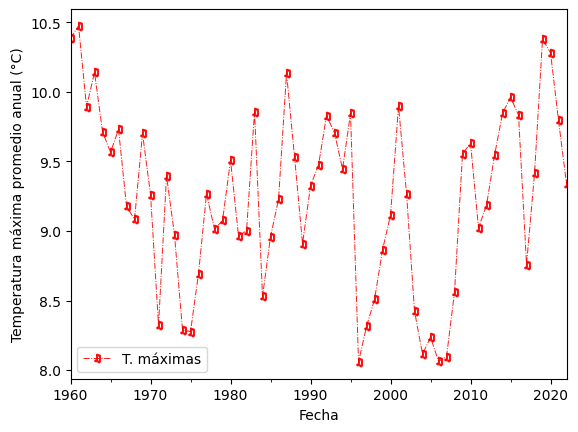

In [136]:
df_Tmax.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura máxima promedio anual (°C)",
                                                   color="r", alpha=0.9, style="-.", lw=.7,
                                                 marker="$\u266B$")
plt.legend(["T. máximas"])
plt.show()

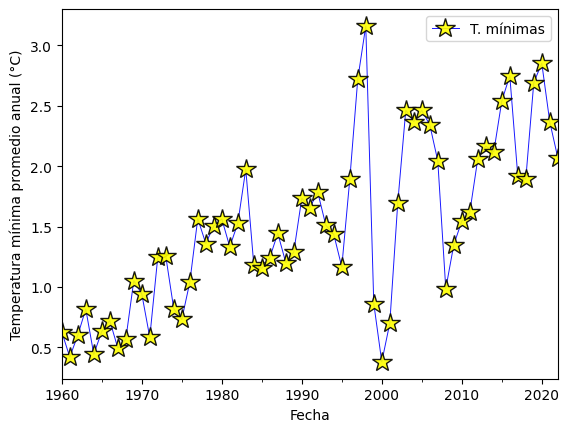

In [137]:
df_Tmin.groupby(pd.Grouper(freq='Y')).mean().plot(legend=False,
                                                   ylabel="Temperatura mínima promedio anual (°C)",
                                                   color="b", alpha=0.9, style="-", lw=.7,
                                                  marker="*",markersize=15,markerfacecolor='yellow',
                                                 markerfacecoloralt='green',markeredgecolor='black',
                                                 markeredgewidth=1)
plt.legend(["T. mínimas"])
plt.show()

<Axes: ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

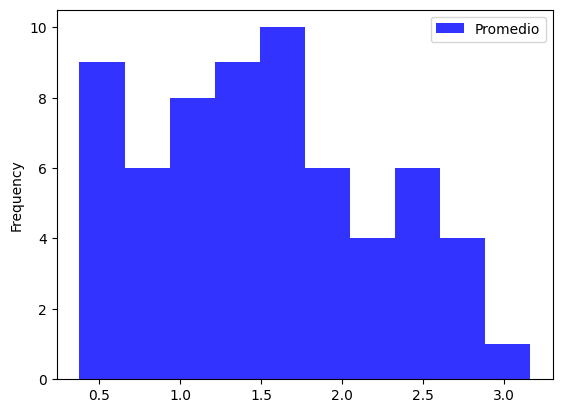

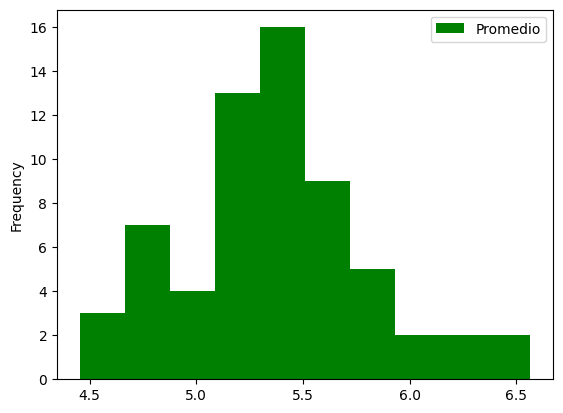

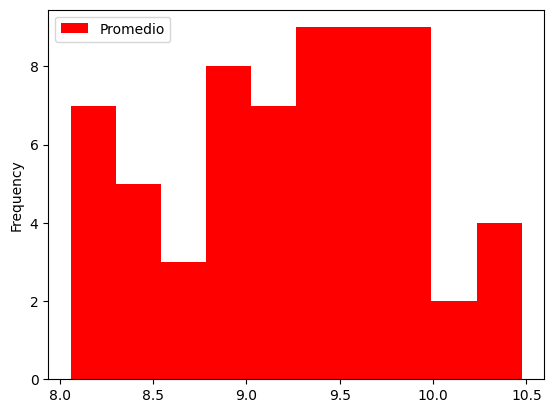

In [138]:
plt.figure()
df_Tmin.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="b", alpha=0.8)
df_Tprom.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="g")
df_Tmax.groupby(pd.Grouper(freq='Y')).mean().plot.hist(color="r")

In [139]:
#Vamos a crear la columna de años y meses para las temperaturas mínimas
df_Tmin["años"] = np.array(df_Tmin.index.year)
df_Tmin["meses"] = np.array(df_Tmin.index.month)

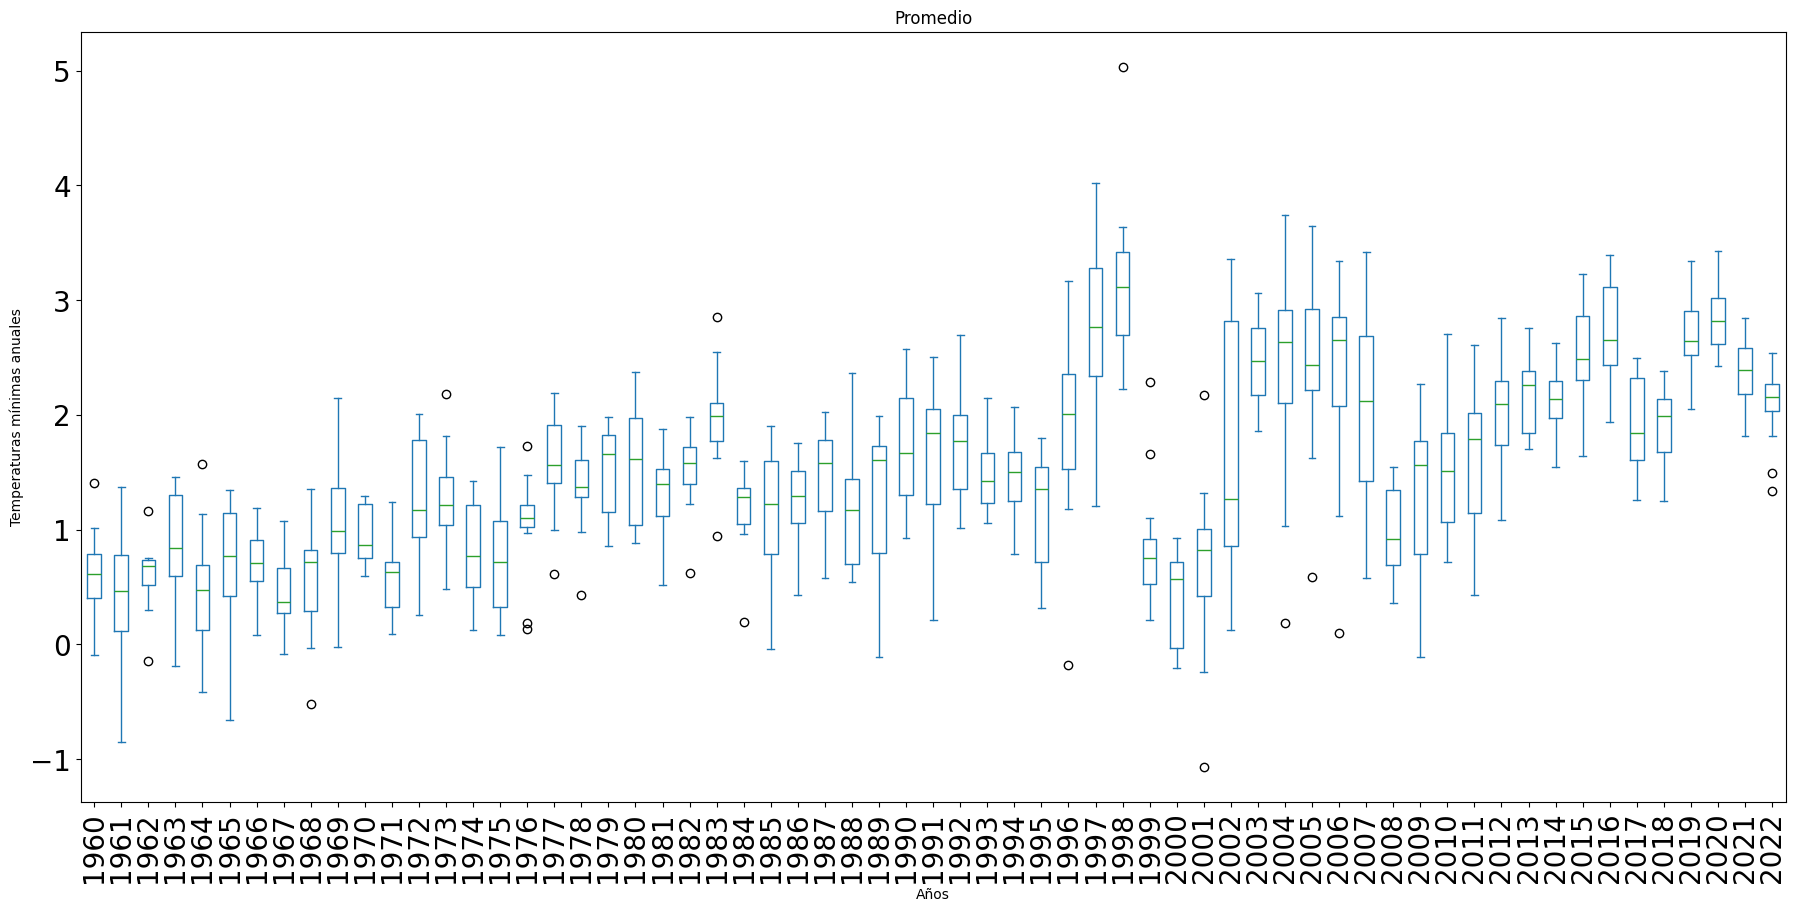

In [140]:
df_Tmin.plot.box(by="años", column=["Promedio"],figsize=(22,10), fontsize=20, 
                 ylabel="Temperaturas mínimas anuales", xlabel="Años", rot=90)
plt.show()

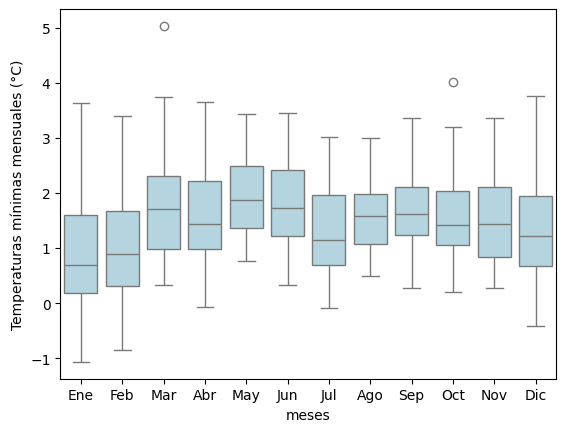

In [141]:
fig, ax = plt.subplots()
sns.boxplot(data=df_Tmin, x="meses", y="Promedio", palette=["lightblue"])
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"])
ax.set_ylabel("Temperaturas mínimas mensuales (°C)")
plt.show()

Exportar datos de estadísticas para el Nevado

In [142]:
geemap.ee_export_image(
    temp_mean.mean(),
    filename = './Raster_Salida/Temp_Mean_{}.tif'.format(name_nevado),
    scale = 4638.312116386398,
    region = nevado.geometry()
)

geemap.ee_export_image(
    temp_max.max(),
    filename = './Raster_Salida/Temp_Max_{}.tif'.format(name_nevado),
    scale = 4638.312116386398,
    region = nevado.geometry()
)

geemap.ee_export_image(
    temp_min.min(),
    filename = './Raster_Salida/Temp_Min_{}.tif'.format(name_nevado),
    scale = 4638.312116386398,
    region = nevado.geometry()
)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\ingju\OneDrive\Documentos\GitHub\MGITG\Análisis_Nevados\Raster_Salida\Temp_Mean_Nevado_Nevados.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\ingju\OneDrive\Documentos\GitHub\MGITG\Análisis_Nevados\Raster_Salida\Temp_Max_Nevado_Nevados.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\ingju\OneDrive\Documentos\GitHub\MGITG\Análisis_Nevados\Raster_Salida\Temp_Min_Nevado_Nevados.tif
